<center><h1>Qi_Hui_HW4</h1></center>
<br>
<br>

Name: Hui Qi
<br>
Github Username: yufeifeiqiqi
<br>
USC ID: 3206742781

### I want to use one late day from my unused six late days.

## 1. Time Series Classification Part 1: Feature Creation/Extraction (HW3 Rerun)

### (a) Obtain Data

Import packages

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import re
import collections
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.metrics import f1_score

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.metrics import confusion_matrix, roc_curve, auc

from imblearn.over_sampling import RandomOverSampler
from sklearn.datasets import make_classification
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegressionCV
import warnings
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

Get the AReM Data Set

In [2]:
def listdir_nohidden(path):
    # Get list of all files/dirs in data folder with *, sort lists
    return sorted(glob.glob(os.path.join(path,"*")))

dirPath = "../data/AReM/"
folderName = ["bending1", "bending2", "cycling", "lying", "sitting", "standing", "walking"]
columnName = ["time", "avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"]


# store all data with key: folder name in a dictionary
datasetDict = {}

trainingSet =[]
testingSet = []

cutoff = 2
count = 0

for folder in folderName:
    datasetList = []
    path = dirPath + folder
    paths_under_onefolder = listdir_nohidden(path)
    #print(paths_under_onefolder)
    
    # \D : Matches any character which is not a decimal digit
    # (...) Matches whatever regular expression is inside the parentheses, and indicates the start and end of a group
    # m.group(1)       # The first parenthesized subgroup.
    paths_under_onefolder = sorted(paths_under_onefolder, key = lambda x: int(re.match("\D*(\d+)",x).group(1)))
    #print(paths_under_onefolder)
    
    if folder not in ["bending1", "bending2"]:
        cutoff = 3
    count = 0
    for file in paths_under_onefolder:
        # read each csv file in folder
        dataset = pd.read_csv(file, skiprows = 5, header = None, names = columnName)
        # deal with none values            
        dataset = dataset.replace(np.nan, 0)
        # put data into a dictionary value as list
        datasetList.append(dataset)
            
        count +=1
        # make less than cutoff (2 or 3) testing cut:
        if count <= cutoff:
            testingSet.append(dataset)
        else:
            trainingSet.append(dataset)
    
    # match key and value for data dictionary
    datasetDict[folder] = datasetList
#datasetDict

### (b) Splitting Data

see part (a)

### (c) Feature Extraction

In [3]:
statCollection  = collections.defaultdict(dict)
instanceNum = 0
for folder in folderName:
    for dataset in datasetDict[folder]:
        instanceNum +=1
        # feature is the time series
        featuresNum = 0
        for column in columnName[1:]:
            featuresNum +=1
            infor = dataset[column].describe()
            #print(infor)
            statCollection[instanceNum]["min" + str(featuresNum)] = infor["min"]
            statCollection[instanceNum]["max" + str(featuresNum)] = infor["max"]
            statCollection[instanceNum]["mean" + str(featuresNum)] = infor["mean"]
            statCollection[instanceNum]["median" + str(featuresNum)] = infor["50%"]
            statCollection[instanceNum]["std" + str(featuresNum)] = infor["std"]
            statCollection[instanceNum]["first quartile" + str(featuresNum)] = infor["25%"]
            statCollection[instanceNum]["third quartile" + str(featuresNum)] = infor["75%"]
tableInfor = pd.DataFrame(statCollection).T
tableInfor

min1   max1      mean1  median1      std1  first quartile1  \
1   37.25  45.00  40.624792    40.50  1.476967            39.25   
2   38.00  45.67  42.812812    42.50  1.435550            42.00   
3   35.00  47.40  43.954500    44.33  1.558835            43.00   
4   33.00  47.75  42.179813    43.50  3.670666            39.15   
5   33.00  45.75  41.678063    41.75  2.243490            41.33   
..    ...    ...        ...      ...       ...              ...   
84  19.50  45.33  33.586875    34.25  4.650935            30.25   
85  19.75  45.50  34.322750    35.25  4.752477            31.00   
86  19.50  46.00  34.546229    35.25  4.842294            31.25   
87  23.50  46.25  34.873229    35.25  4.531720            31.75   
88  19.25  44.00  34.473188    35.00  4.796705            31.25   

    third quartile1  min2   max2     mean2  ...      std5  first quartile5  \
1           42.0000   0.0   1.30  0.358604  ...  2.188449          33.0000   
2           43.6700   0.0   1.22  0.372438  ...  1.995255          32.0000   
3           45.0000   0.0   1.70  0.426250  ...  1.999604          35.3625   
4           45.0000   0.0   3.00  0.696042  ...  3.849448          30.4575   
5           42.7500   0.0   2.83  0.535979  ...  2.411026          28.4575   
..              ...   ...    ...       ...  ...       ...              ...   
84          37.0000   0.0  14.67  4.576562  ...  3.283983          13.7300   
85          38.0000   0.0  13.47  4.456333  ...  3.119856          13.5000   
86          37.8125   0.0  12.47  4.371958  ...  2.823124          14.0000   
87          38.2500   0.0  14.82  4.380583  ...  3.131076          13.7500   
88          38.0000   0.0  13.86  4.359312  ...  3.156320          13.7300   

    third quartile5  min6   max6     mean6  median6      std6  \
1             36.00  0.00   1.92  0.570583     0.43  0.582915   
2             34.50  0.00   3.11  0.571083     0.43  0.601010   
3             36.50  0.00   1.79  0.493292     0.43  0.513506   
4             36.33  0.00   2.18  0.613521     0.50  0.524317   
5             31.25  0.00   1.79  0.383292     0.43  0.389164   
..              ...   ...    ...       ...      ...       ...   
84            18.25  0.00   8.32  3.259729     3.11  1.640243   
85            17.75  0.00   9.67  3.432562     3.20  1.732727   
86            17.75  0.00  10.00  3.338125     3.08  1.656742   
87            18.00  0.00   9.51  3.424646     3.27  1.690960   
88            17.75  0.43   9.00  3.340458     3.09  1.699114   

    first quartile6  third quartile6  
1            0.0000           1.3000  
2            0.0000           1.3000  
3            0.0000           0.9400  
4            0.0000           1.0000  
5            0.0000           0.5000  
..              ...              ...  
84           2.0500           4.3225  
85           2.1575           4.5650  
86           2.1600           4.3350  
87           2.1700           4.5000  
88           2.1200           4.3750  

[88 rows x 42 columns]

## 2. Time Series Classification Part 2: Binary and Multiclass Classification

### (a) Binary Classification Using Logistic Regression

#### i. Plots

(From 1(c)iv) <br>
I will select mean, standard deviatoin, and median. Mean can help us detect the trend in time series. Standard deviation can help us detect the seasonality and slow or fast variation. If the difference between mean and median is large, we might have some outliers.

In [4]:
#trainingSet

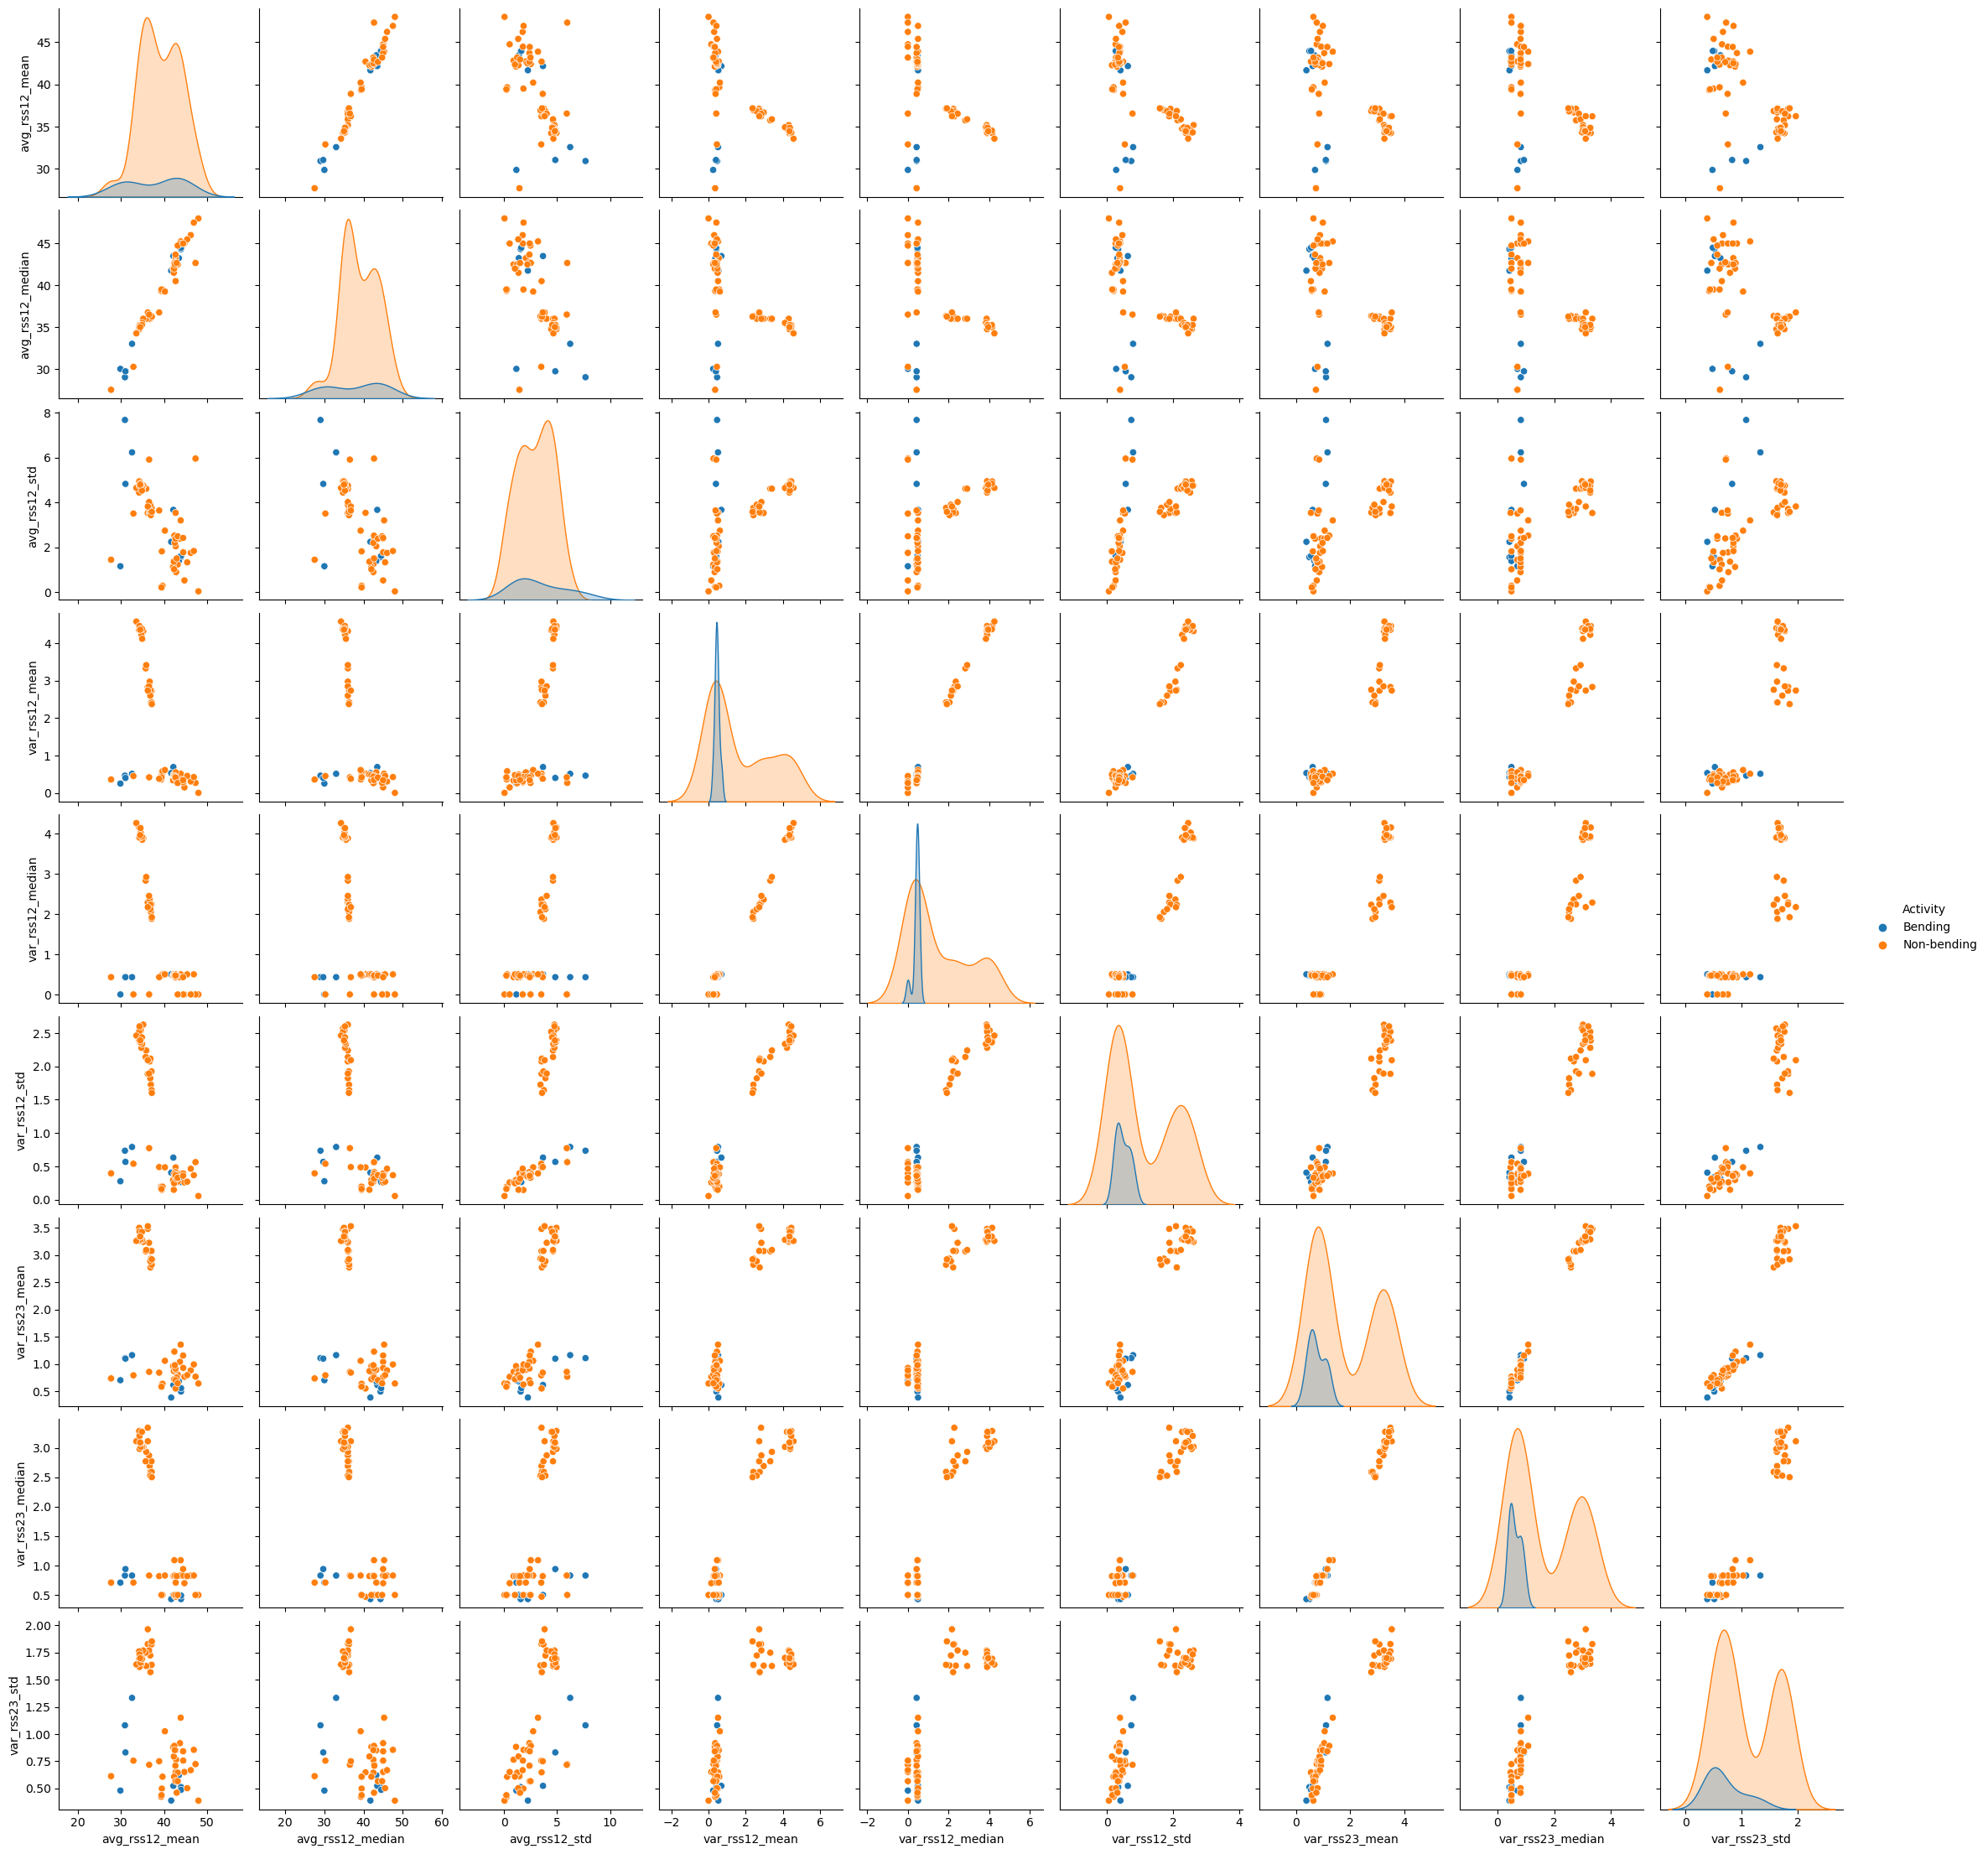

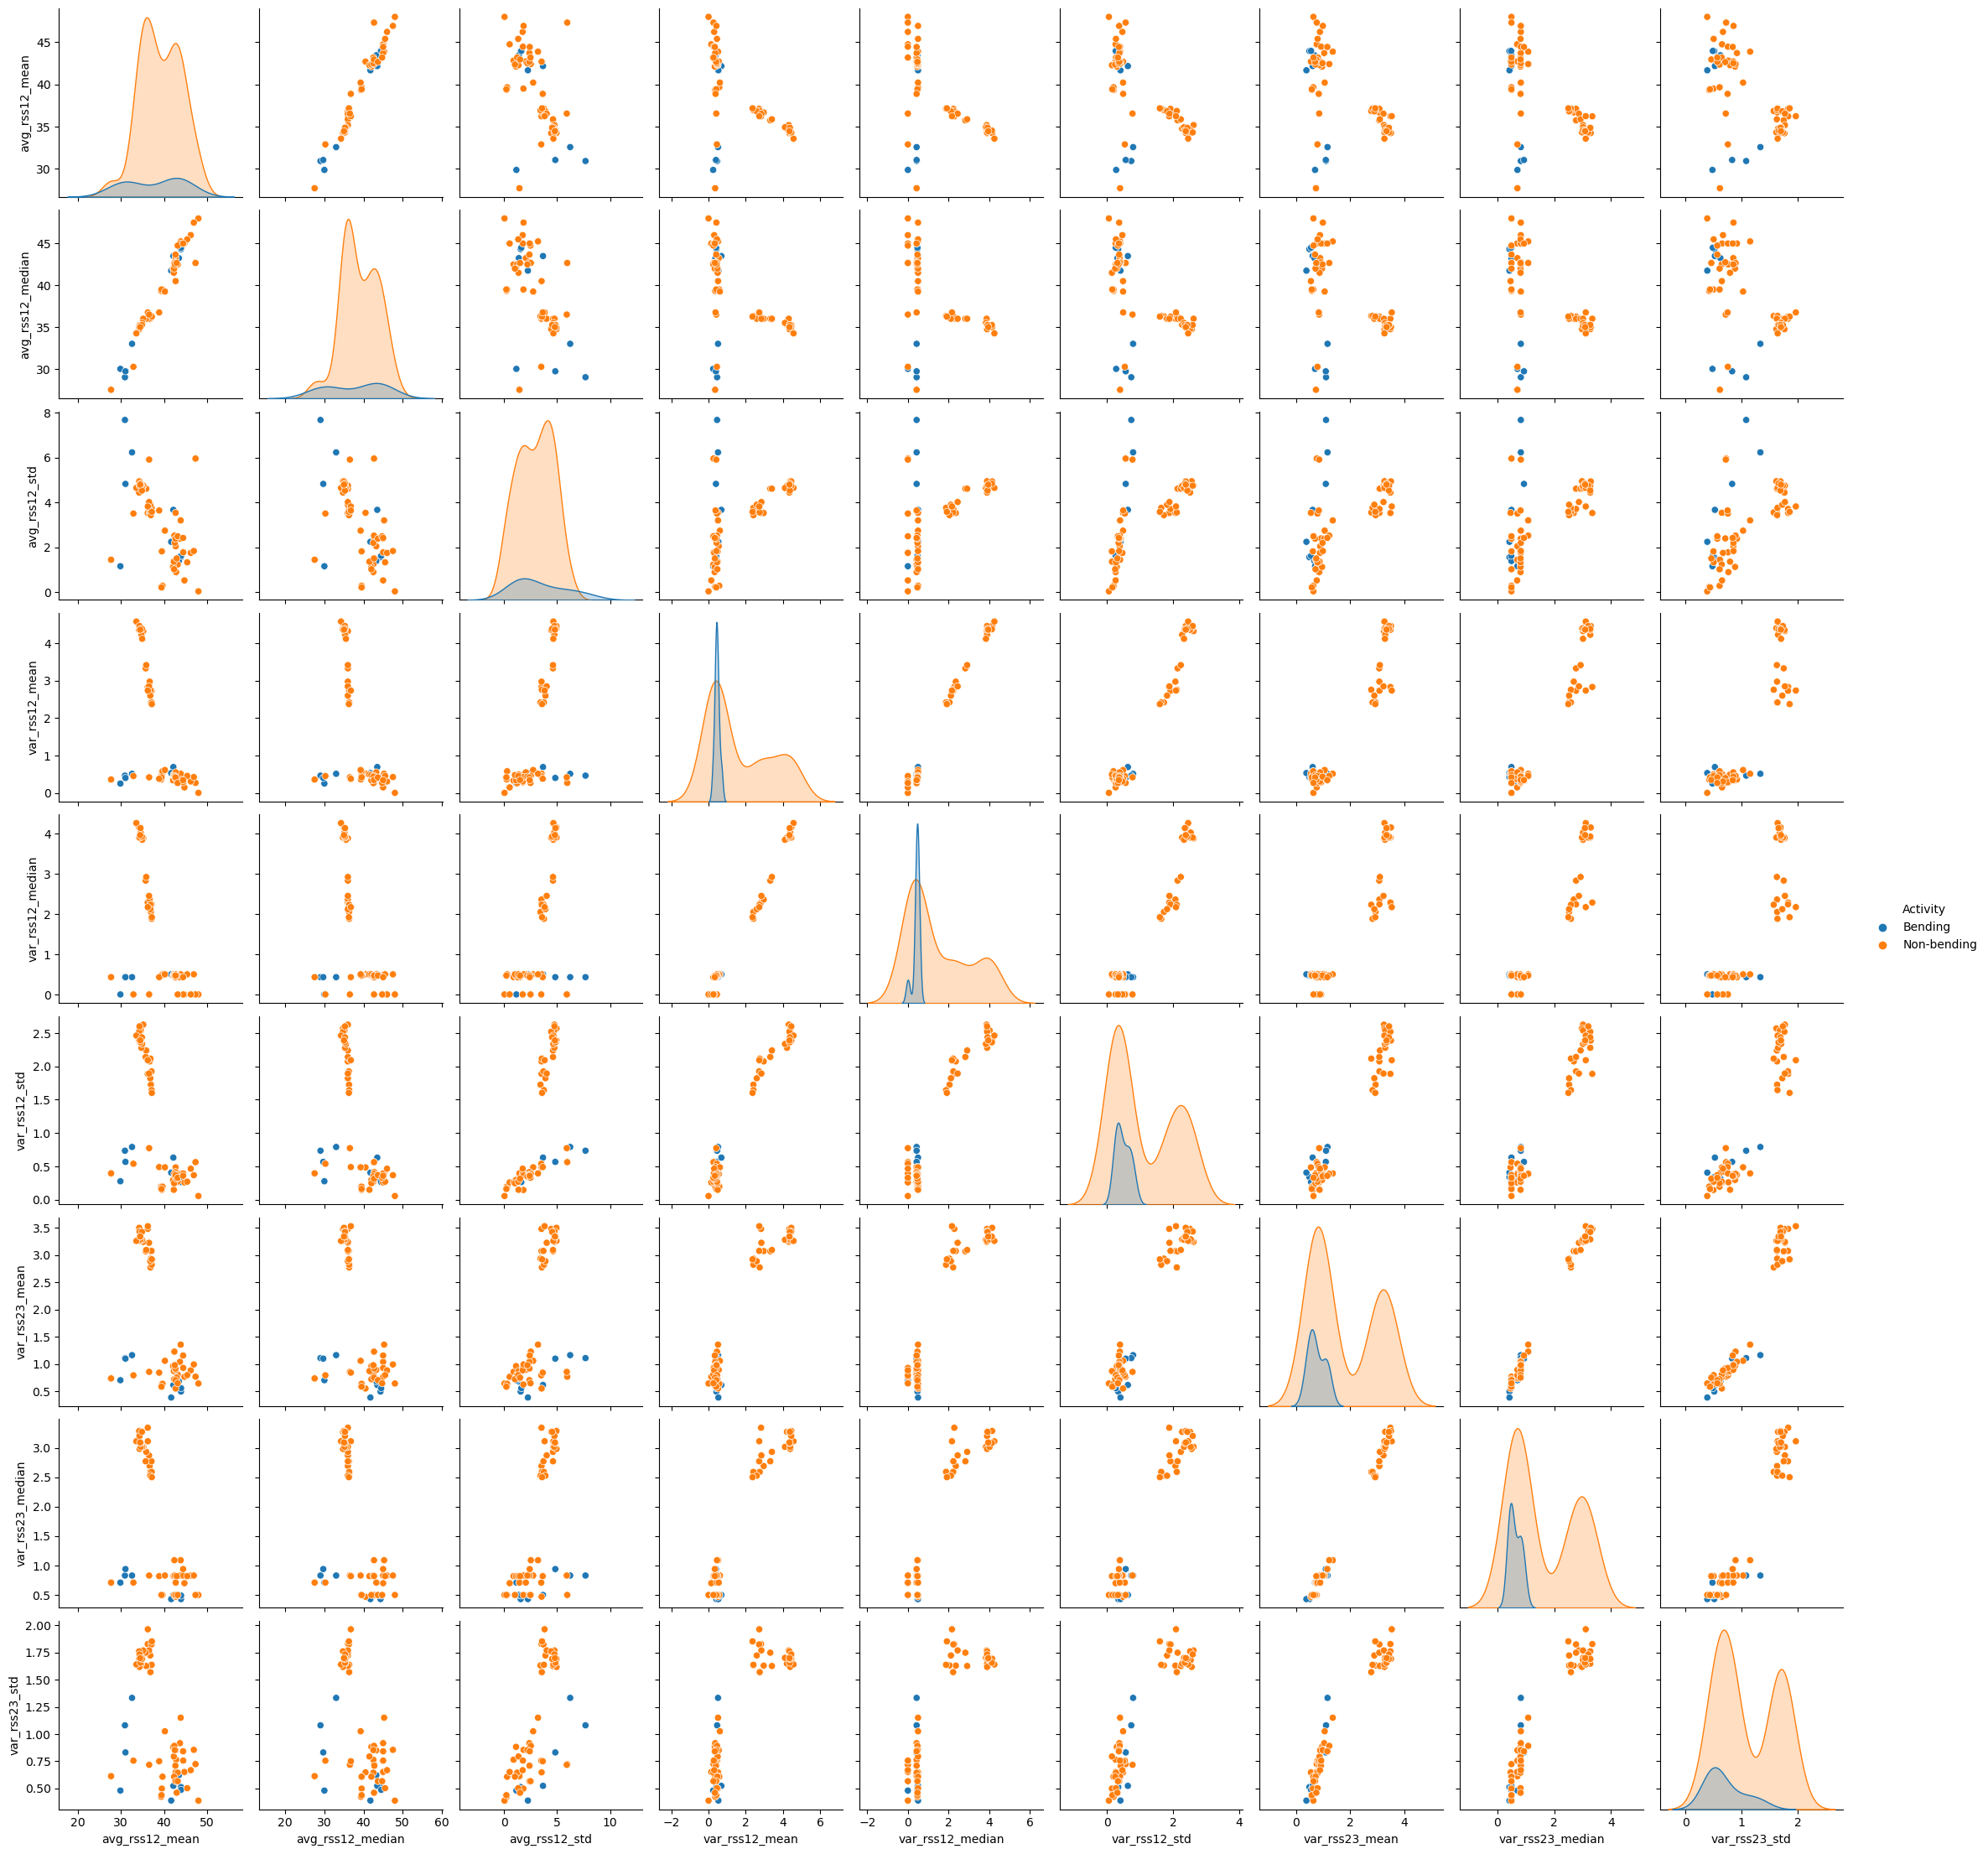

In [5]:
# Bending activity : 1 ; non-bending activity :0
# 69 rows in training Set, 19 rows in test Set
# datasets 3-7 in bending 1 are in training Set, datasets 3-6 in bending 2 are in training Set

def drawScatterPlots(timeSeries, trainingSet):
    feature_df = {}
    # store mean, median, std of time series 1, 2, 6
    for feature in timeSeries:
        meanList = []
        stdList = []
        medianList = []
        bending_activity = []
        count = 0
        for s in trainingSet:
            count += 1
            # store mean, median, std of time series 1, 2,6
            infor = s[feature].describe()
            meanList.append(infor['mean'])
            medianList.append(infor['50%'])
            stdList.append(infor['std'])
            # 5 + 4 = 9. 5 files in bending 1, 4 file2 in bending 2 are in traning Set
            if count <= 9:
                bending_activity.append('Bending')
            else:
                bending_activity.append('Non-bending')
        feature_df['Activity'] = bending_activity
        feature_df[str(feature) + '_mean'] = meanList
        feature_df[str(feature) + '_median'] = medianList
        feature_df[str(feature) + '_std'] = stdList
        
    #feature_df
    df = pd.DataFrame(feature_df)
    #return df
    
    # scatter plots on class activity
    sns.pairplot(df, hue='Activity')
    plt.show()


timeSeries = ['avg_rss12', 'var_rss12', 'var_rss23']
drawScatterPlots(timeSeries, trainingSet)
     

#### ii. Splitted Plots

There is no considerable difference between these two results.

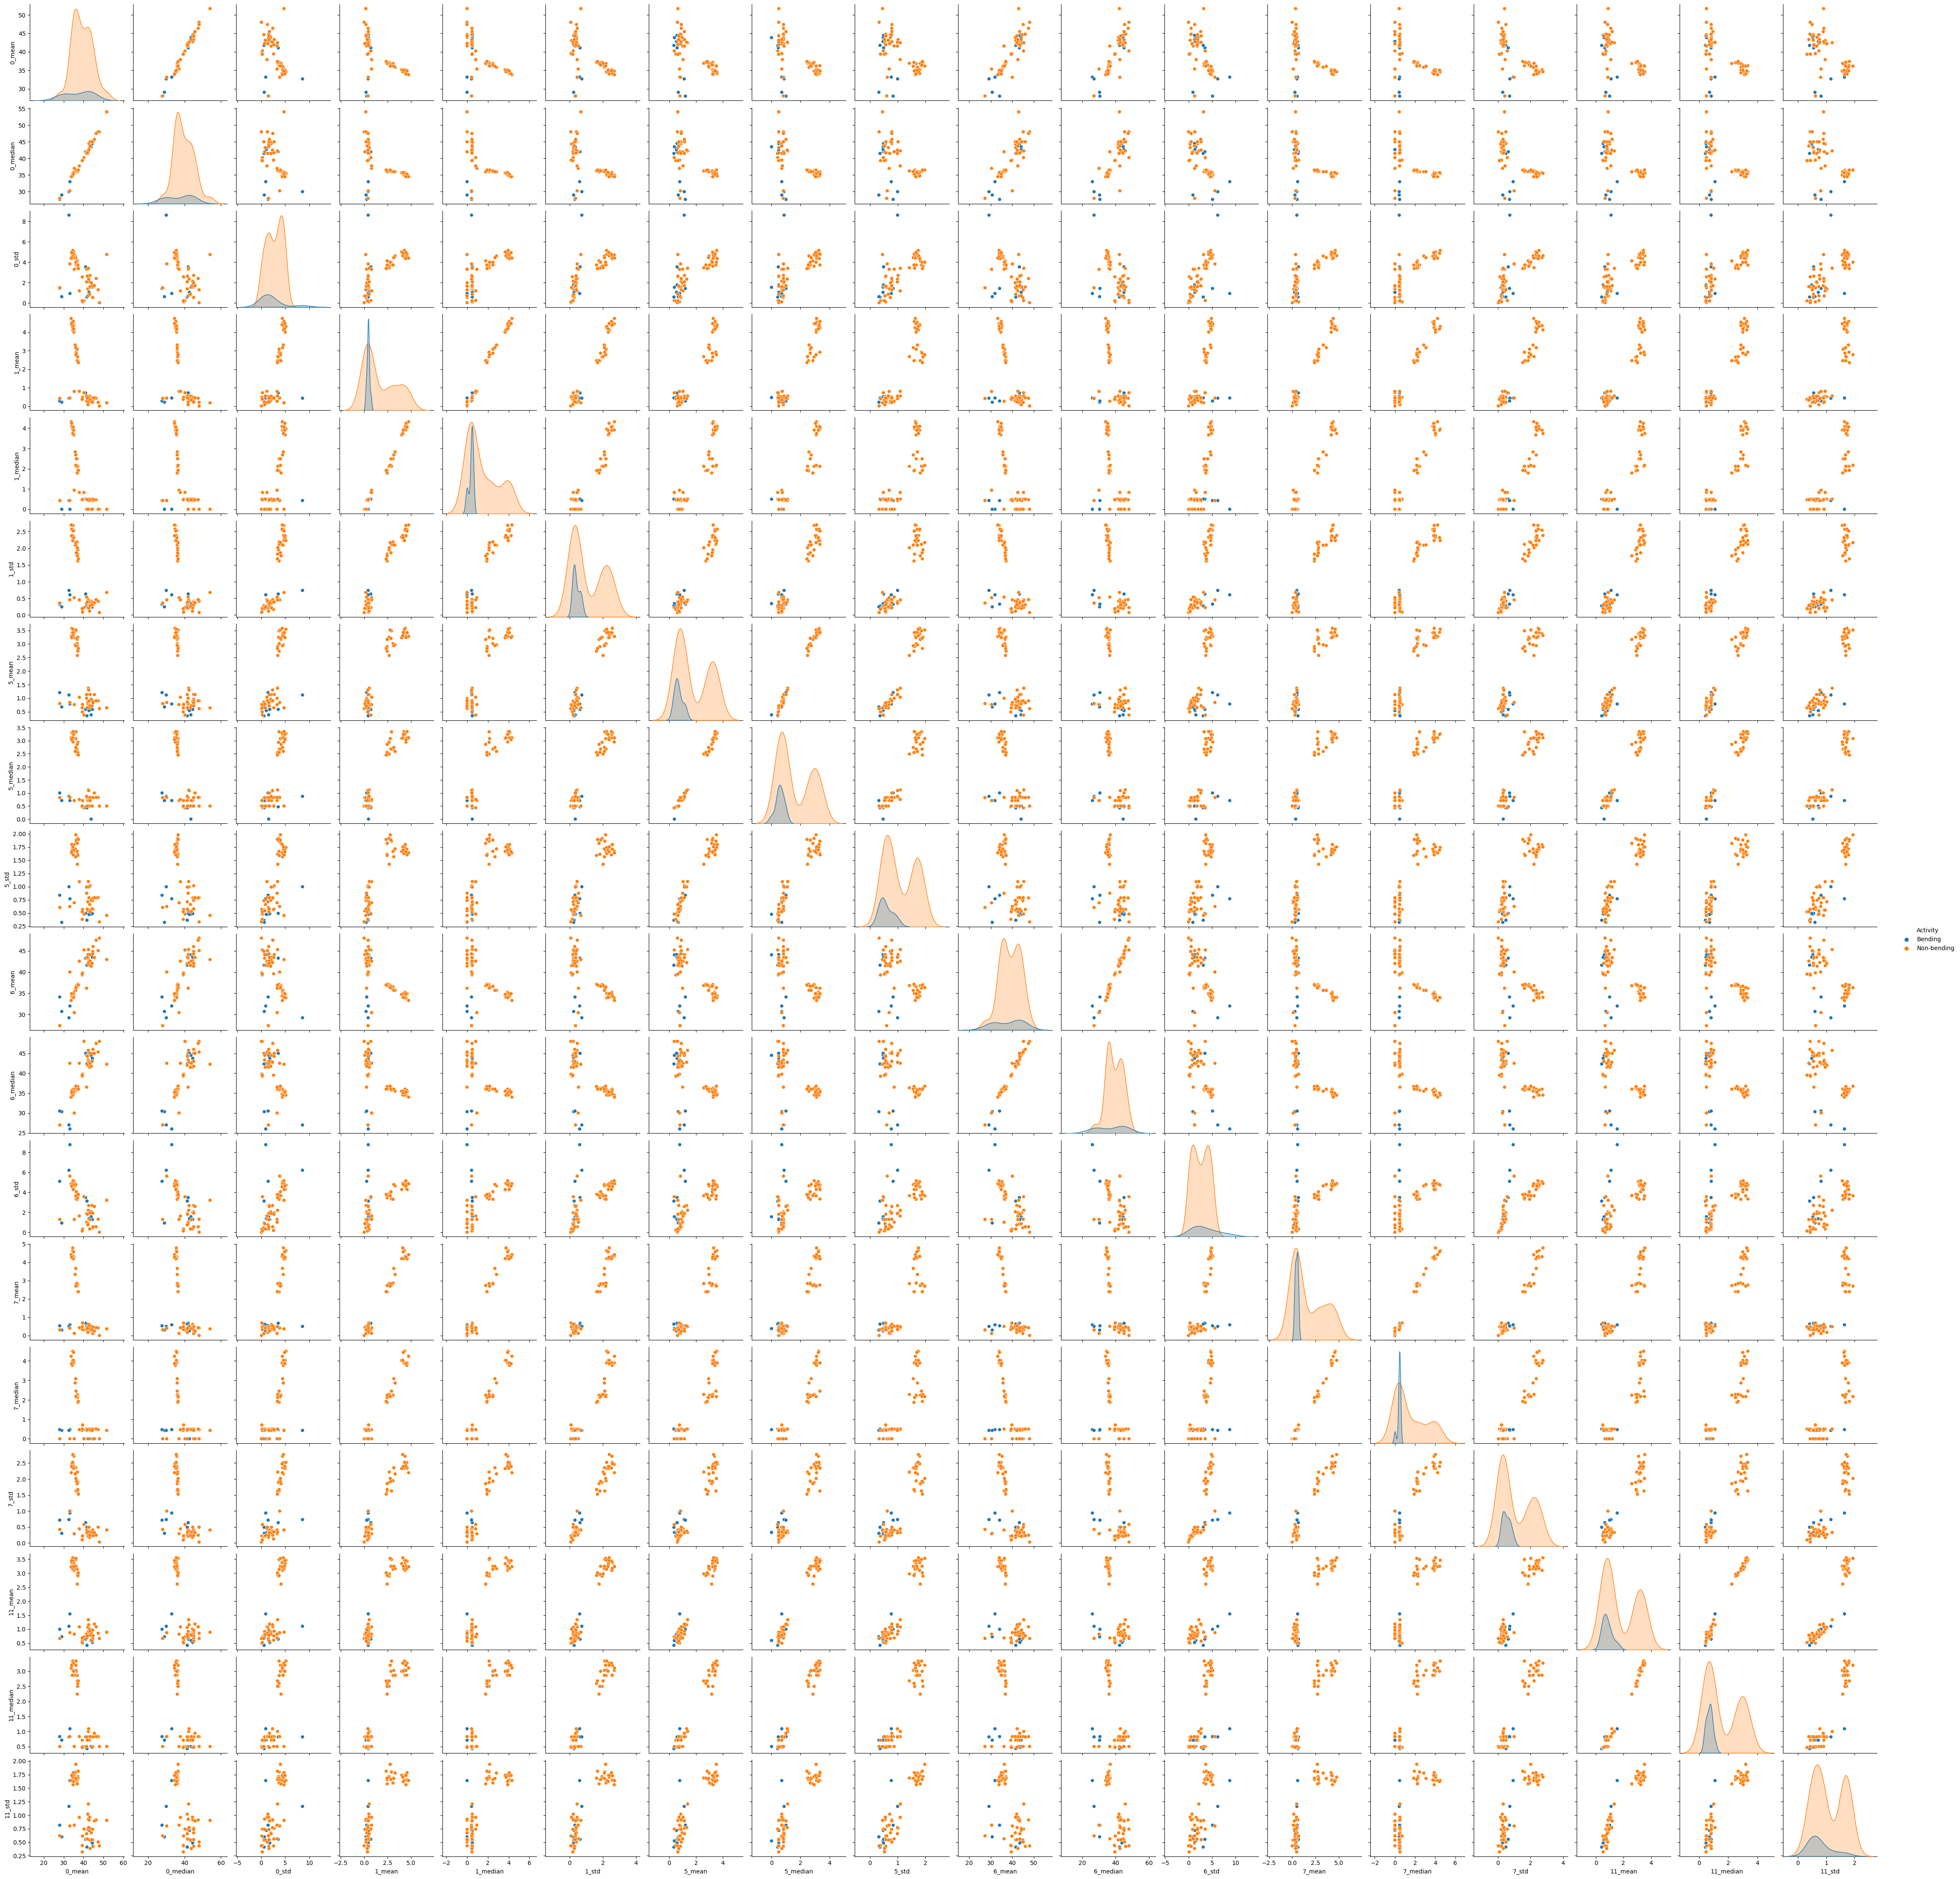

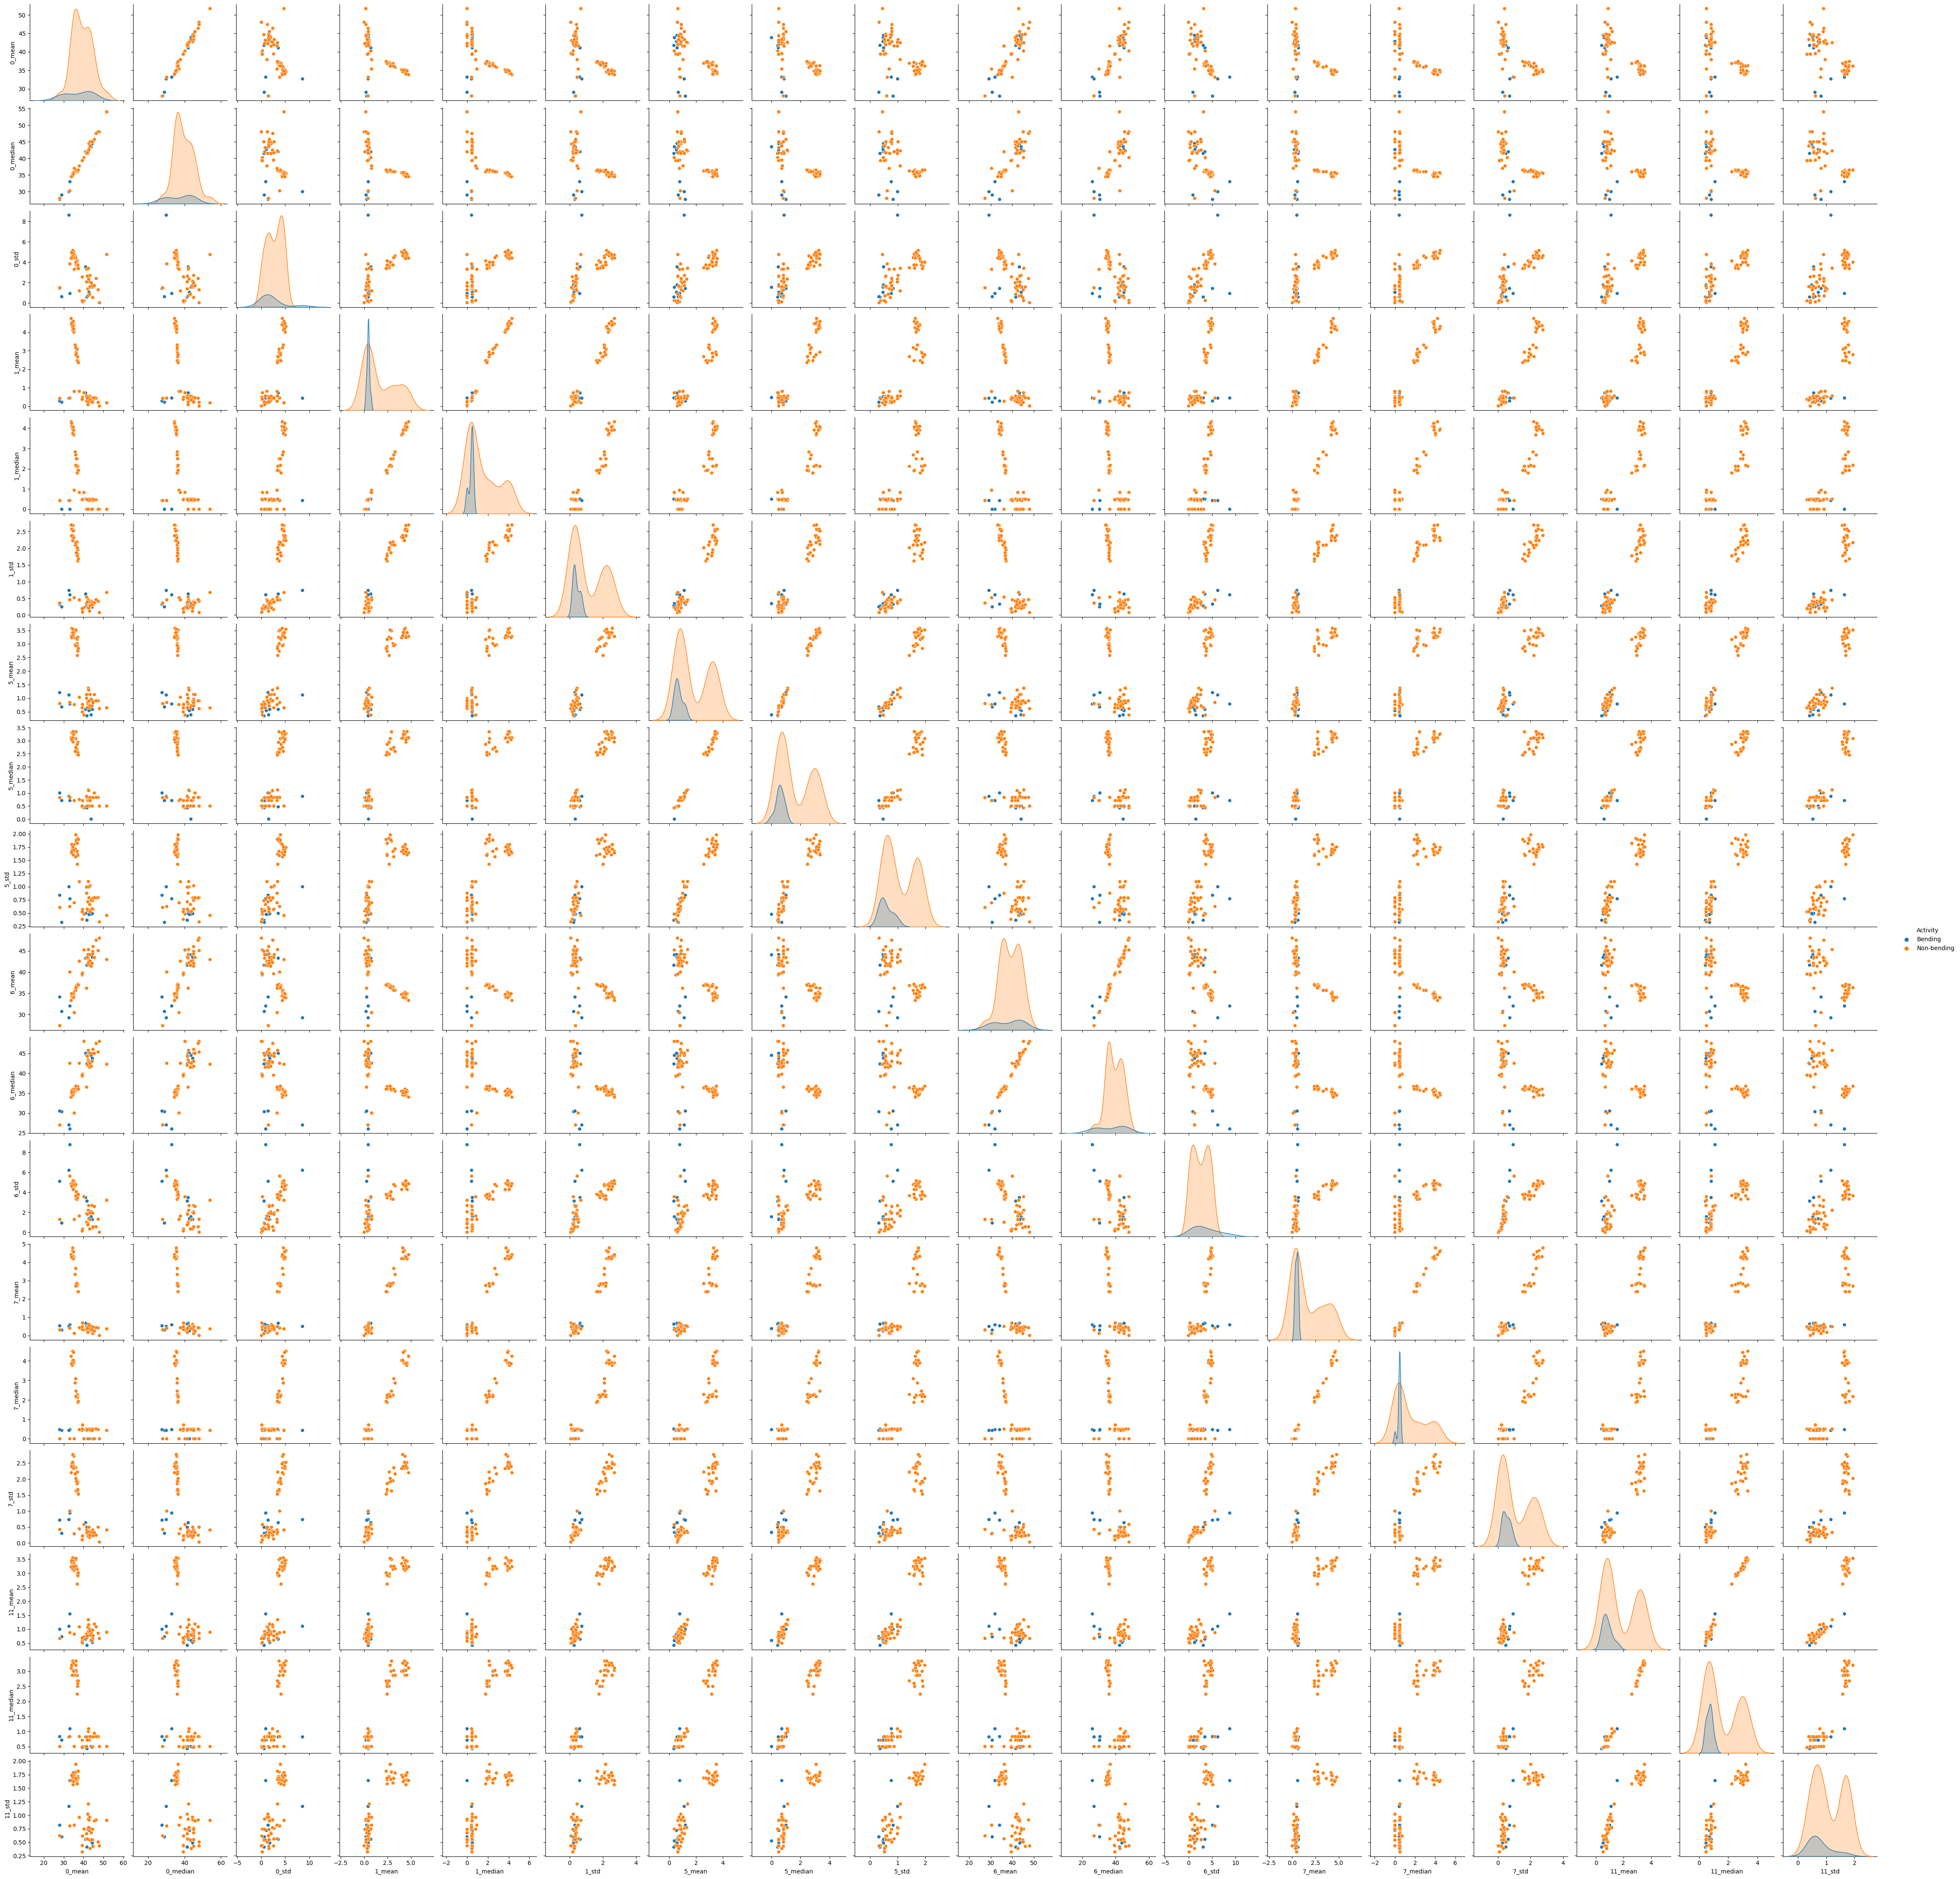

In [6]:
def breakTimeSeries(dataset, num_subset):
    newDataSet = []
    for df in dataset:
        size = round(len(df)/num_subset)
        list_of_dfs = [df.iloc[i:i+size-1,:] for i in range(0, len(df), size)]
        #print(list_of_dfs)
        tmp_df = pd.DataFrame()
        for s in range(num_subset):
            # rearrange index for concating
            list_of_dfs[s].index = range(len(list_of_dfs[s]))
            # need to remove 'time' column, concatenate DataFrames horizontally with axis = 1
            tmp_df = pd.concat([list_of_dfs[s].iloc[:, 1:], tmp_df], axis=1, ignore_index=True)
        newDataSet.append(tmp_df)
        #print(newDataSet)
    return newDataSet

timeSeries = [0, 1, 5, 6, 7, 11]
new_trainingSet = breakTimeSeries(trainingSet, 2)
drawScatterPlots(timeSeries, new_trainingSet)

#### iii. Time Series Segments

In [7]:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
# https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-definitions
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
# https://github.com/SuprajaKrovvidi/DSCI-552-Machine-Learning-for-Data-Science/blob/master/Homework3/notebook/DSCI552_HW3_Ruihao_Wang_9867439484.ipynb
# use all the time series but you will only use the 3 features you chose in HW3.  
# for L=20 you will have 360 features.

#### Codes for this question run very long, so I attach the screen shot images below.

#### From pictures below, there are many (l,p) pairs having f1 score close to 1. I will choose the (l,p) pair with f1 close to 1 and also having the smallest number of features (p). <br>
#### I choose l = 17 and p =3. Indexs are [30, 264, 265].

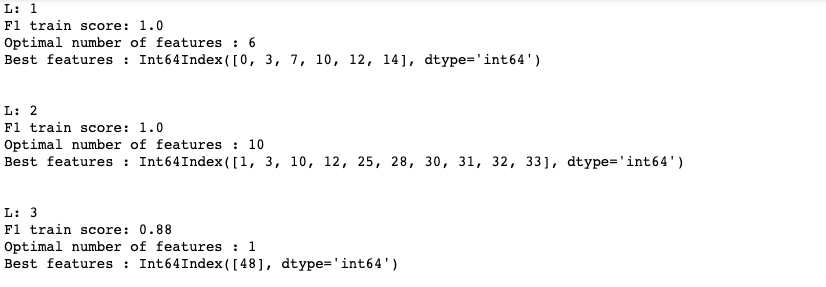

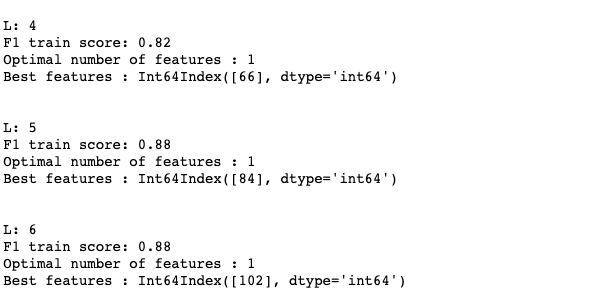

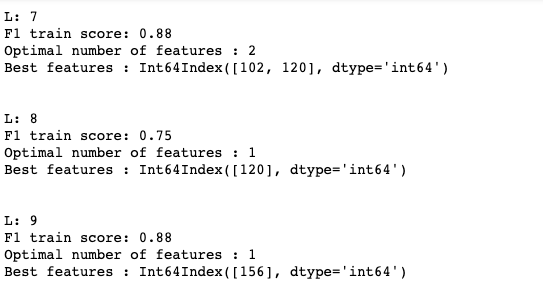

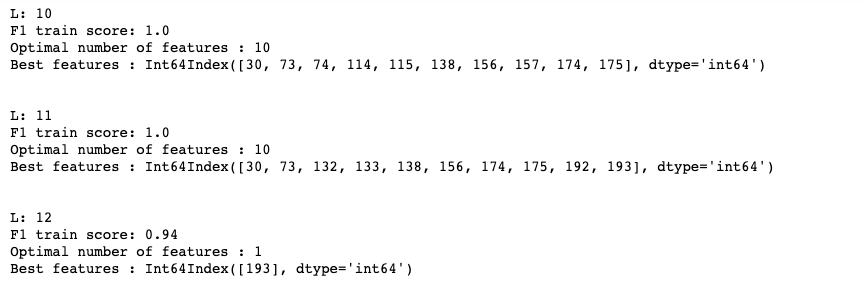

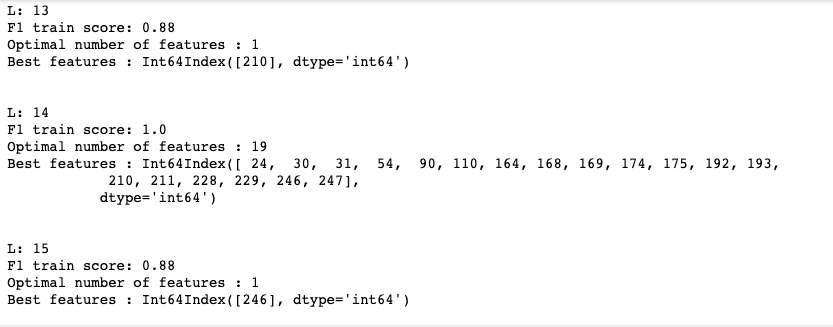

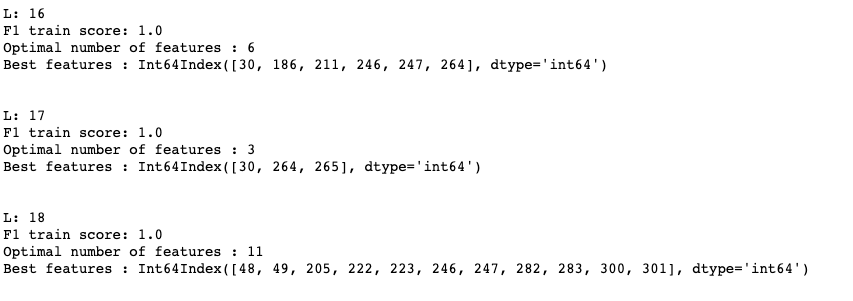

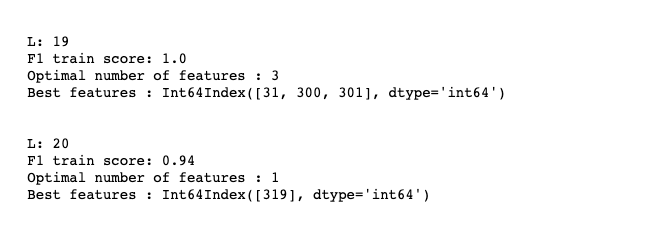

In [8]:
# get our X and Y, also classify them with 1 and 0
def getTarget(dataset, cutoffBending=9):
    count = 0
    trainY = list()
    trainX = list()
    # bending is 1, non-bending is 0
    for df in dataset:
    #     print(df)
        count += 1
        if count <= cutoffBending:
            trainY.append(1)
        else:
            trainY.append(0)
        trainX.append(df)
    
    return trainX, trainY

def TimeDomainFeatures(datasetList):
    rowList = []
    data = []
    for dataset in datasetList:
        for col in dataset:
            infor = dataset[col].describe()
            rowList.append(infor['mean'])
            rowList.append(infor['50%'])
            rowList.append(infor['std'])
        data.append(rowList)
        rowList = []
    data = pd.DataFrame(data)
    
    #print(data)
    return data

In [9]:
for l in range(1,21):
    new_trainingSet = breakTimeSeries(trainingSet, l)
    trainX, trainY = getTarget(new_trainingSet)
    #print(trainX)
    #print(trainY)
    trainX = TimeDomainFeatures(trainX)
    model = LogisticRegression(solver='lbfgs', max_iter=1000)
    
    
    # Recursive feature elimination with cross-validation to select features
    rfe = RFECV(model, step = 1, cv = 5, scoring='accuracy')
    rfe = rfe.fit(trainX, trainY)
    F1_Score = f1_score(trainY, rfe.predict(trainX))
    print('L:', l)
    print('F1 train score:', round(F1_Score, 2))
    print('Optimal number of features (p) :', rfe.n_features_)
    print('Best features :', trainX.columns[rfe.support_])
    print('\n')
    

L: 1
F1 train score: 1.0
Optimal number of features (p) : 6
Best features : Int64Index([0, 3, 7, 10, 12, 14], dtype='int64')


L: 2
F1 train score: 1.0
Optimal number of features (p) : 10
Best features : Int64Index([1, 3, 10, 12, 25, 28, 30, 31, 32, 33], dtype='int64')


L: 3
F1 train score: 0.88
Optimal number of features (p) : 1
Best features : Int64Index([48], dtype='int64')


L: 4
F1 train score: 0.82
Optimal number of features (p) : 1
Best features : Int64Index([66], dtype='int64')


L: 5
F1 train score: 0.88
Optimal number of features (p) : 1
Best features : Int64Index([84], dtype='int64')


L: 6
F1 train score: 0.88
Optimal number of features (p) : 1
Best features : Int64Index([102], dtype='int64')


L: 7
F1 train score: 0.88
Optimal number of features (p) : 2
Best features : Int64Index([102, 120], dtype='int64')


L: 8
F1 train score: 0.75
Optimal number of features (p) : 1
Best features : Int64Index([120], dtype='int64')


L: 9
F1 train score: 0.88
Optimal number of features (

#### iv. Confusion Matrix

In [10]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
# https://www.statology.org/statsmodels-logistic-regression/
# https://data.library.virginia.edu/logistic-regression-four-ways-with-python/

In [11]:
new_trainingSet = breakTimeSeries(trainingSet, 17)
trainX, trainY = getTarget(new_trainingSet)
trainX = TimeDomainFeatures(trainX)
#print(trainX)
trainX = trainX.iloc[:, [30, 264, 265]]

In [12]:
# I use sm.logit. The coefficient result is very large, which seems wrong. But i do not know how to fix it.
# build model, add constant to features
trainX_const = sm.add_constant(trainX)
#print(trainX_const)
model = sm.Logit(trainY, trainX_const)


logitres = model.fit(method='bfgs')
print(logitres.summary())

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 33
         Function evaluations: 38
         Gradient evaluations: 38
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   69
Model:                          Logit   Df Residuals:                       65
Method:                           MLE   Df Model:                            3
Date:                Sat, 04 Mar 2023   Pseudo R-squ.:                   1.000
Time:                        00:04:26   Log-Likelihood:            -2.6251e-05
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 1.481e-11
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -454.6971   4.32e+05     -

In [13]:
logreg = LogisticRegression()
logreg.fit(trainX,trainY)
print(logreg.coef_)

yPredict = logreg.predict(trainX)
conf_Matrix = confusion_matrix(trainY, yPredict)
print('confusion matrix\n', conf_Matrix)

[[0.57729682 0.81274314 0.70425477]]
confusion matrix
 [[60  0]
 [ 0  9]]


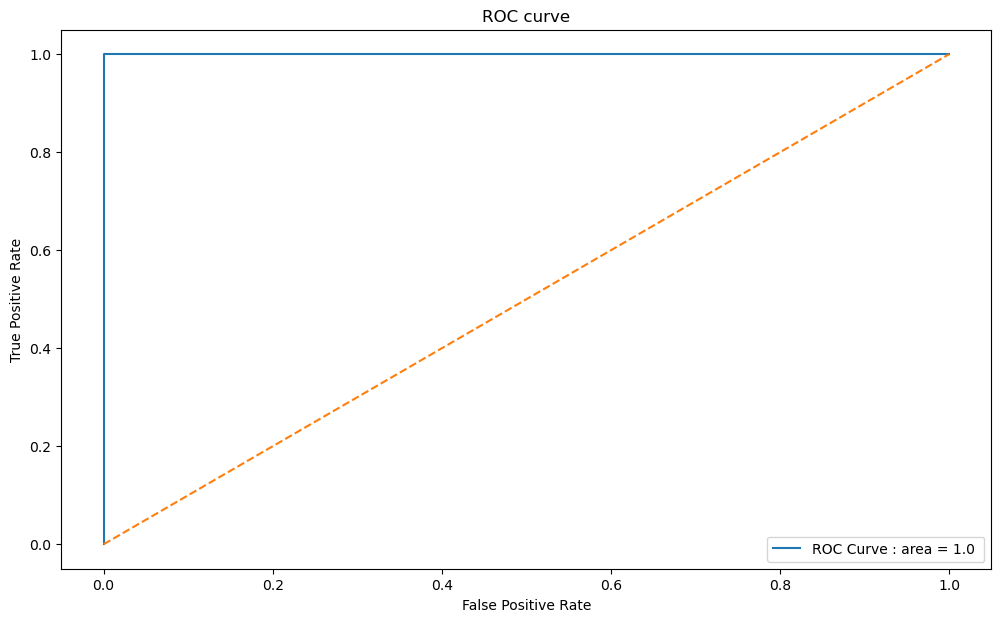

In [14]:
y_score = logreg.fit(trainX, trainY).predict_proba(trainX)
#print(y_score)

fpr, tpr, thresholds = roc_curve(trainY, y_score[:,1])
roc_auc = auc(fpr,tpr)

fig, axes = plt.subplots(figsize=(12, 7))
roc_auc = auc(fpr, tpr)
axes.plot(fpr, tpr, label="ROC Curve : area = {} ".format(roc_auc))
axes.plot([0, 1], [0, 1], "--")
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")
axes.legend()
axes.set_title("ROC curve")
plt.show()

#### v. Test Classifier

In [15]:
# get train data and label
new_trainingSet = breakTimeSeries(trainingSet, 17)
trainX, trainY = getTarget(new_trainingSet)
trainX = TimeDomainFeatures(trainX)
trainX = trainX.iloc[:, [30, 264, 265]]

# get test data and label
new_testingSet = breakTimeSeries(testingSet, 17)
# notice that only 4 bendings in test set
testX, testY = getTarget(new_testingSet, 4)
testX = TimeDomainFeatures(testX)
testX = testX.iloc[:, [30, 264, 265]]

model = LogisticRegression()
clf = model.fit(trainX,trainY)

train_clf_score = clf.score(trainX, trainY)
test_clf_score = clf.score(testX, testY)

print('train cross-validation score :', train_clf_score)
print('test cross-validation score :', test_clf_score)
print('\n')

train cross-validation score : 1.0
test cross-validation score : 0.8947368421052632




#### vi. Separation

#### Yes, it is obvious from the ROC curve figure. 

#### vii. Imbalance

#### Yes, there are imbalance classes becasue there are 9 bending classes and 60 non-bending classes in training set. I have oversamplied for classes in training set.

In [16]:
# https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/
# https://imbalanced-learn.org/stable/over_sampling.html
# https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc

confusion matrix
 [[60  0]
 [ 0 60]]


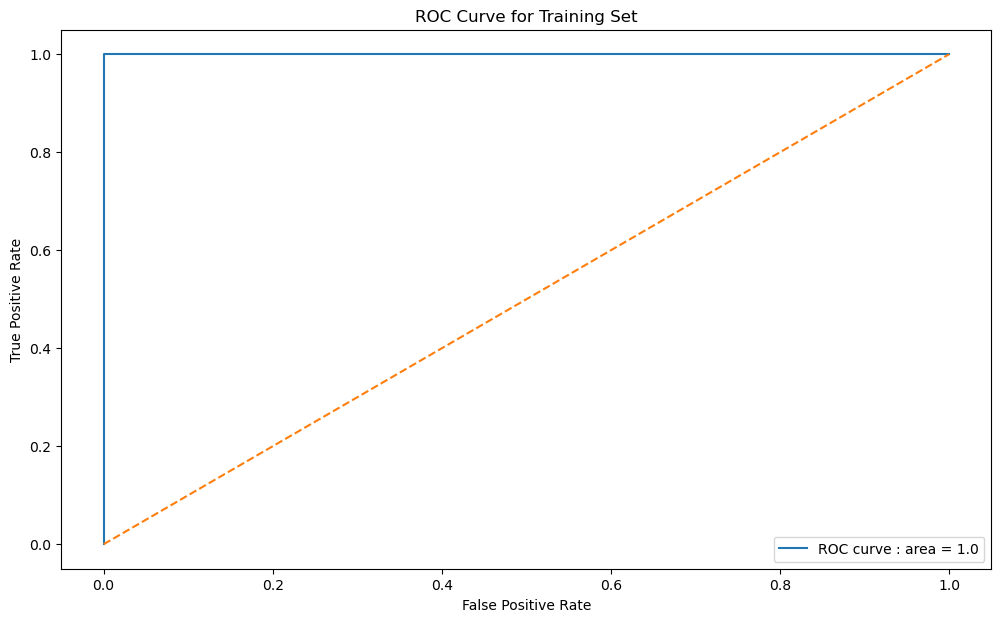

In [17]:
# training set

# generate new samples by randomly sampling with replacement the current available samples
ros = RandomOverSampler(random_state = 30)
X_resampled, y_resampled = ros.fit_resample(trainX, trainY)

logreg = LogisticRegression()
# fit the model with data
logreg.fit(X_resampled,y_resampled)

yPredict = logreg.predict(X_resampled)
conf_Matrix = confusion_matrix(y_resampled, yPredict)
print('confusion matrix\n', conf_Matrix)

# plot ROC
y_score = logreg.fit(X_resampled, y_resampled).decision_function(X_resampled)

# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_resampled, y_score) 
# compute AUC 
roc_auc = auc(fpr,tpr)


fig, axes = plt.subplots(figsize=(12, 7))
axes.plot(fpr, tpr,  label=f'ROC curve : area = {roc_auc}')
axes.plot([0, 1], [0, 1], linestyle='--')

axes.set_xlabel('False Positive Rate')
axes.set_ylabel('True Positive Rate')
axes.set_title('ROC Curve for Training Set')
axes.legend(loc="lower right")
plt.show()


confusion matrix
 [[14  1]
 [ 1  3]]


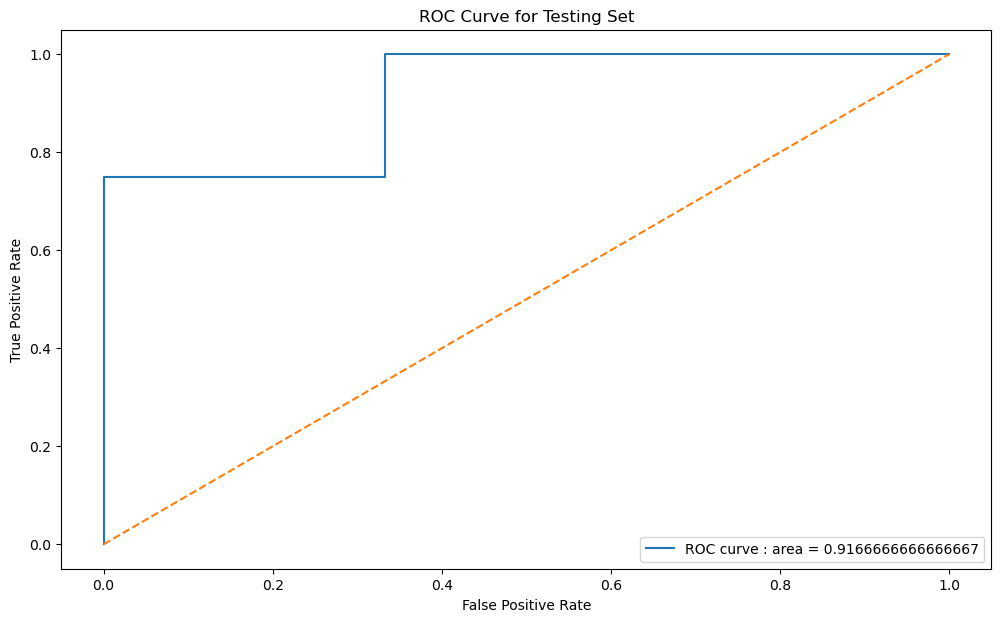

In [18]:
# testing set

# generate new samples by randomly sampling with replacement the current available samples
ros = RandomOverSampler(random_state = 30)
X_resampled, y_resampled = ros.fit_resample(trainX, trainY)

logreg = LogisticRegression()
# fit the model with data
clf = logreg.fit(X_resampled,y_resampled)

yPredict_testing = clf.predict(testX)
conf_Matrix = confusion_matrix(testY, yPredict_testing)
print('confusion matrix\n', conf_Matrix)

# plot ROC
y_score_testing = clf.fit(X_resampled, y_resampled).decision_function(testX)

# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(testY, y_score_testing) 
# compute AUC 
roc_auc = auc(fpr,tpr)


fig, axes = plt.subplots(figsize=(12, 7))
axes.plot(fpr, tpr,  label=f'ROC curve : area = {roc_auc}')
axes.plot([0, 1], [0, 1], linestyle='--')

axes.set_xlabel('False Positive Rate')
axes.set_ylabel('True Positive Rate')
axes.set_title('ROC Curve for Testing Set')
axes.legend(loc="lower right")
plt.show()

### (b) Binary Classification Using L1-penalized logistic regression

#### i. Time Series Segments

In [19]:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html
# https://stackoverflow.com/questions/14463277/how-to-disable-python-warnings

In [20]:
# have many ConvergenceWarning even after set solver and max_iter, I import warnings

warnings.filterwarnings("ignore")
for l in range(1,21):
    newTrainSet = breakTimeSeries(trainingSet, l)
    trainX, trainY = getTarget(newTrainSet)
    trainX = TimeDomainFeatures(trainX)
    
    # normalized data
    xTrainNormalization = preprocessing.scale(trainX)
    model = LogisticRegressionCV(penalty='l1', cv = 5, solver = 'liblinear', max_iter=1000, scoring = 'accuracy')
    result = model.fit(xTrainNormalization, trainY)
    score = result.score(xTrainNormalization, trainY)
    print('L:', l, '\tAccuracy:', score) 

L: 1 	Accuracy: 1.0
L: 2 	Accuracy: 1.0
L: 3 	Accuracy: 0.9710144927536232
L: 4 	Accuracy: 0.9710144927536232
L: 5 	Accuracy: 1.0
L: 6 	Accuracy: 1.0
L: 7 	Accuracy: 0.9710144927536232
L: 8 	Accuracy: 1.0
L: 9 	Accuracy: 0.9710144927536232
L: 10 	Accuracy: 1.0
L: 11 	Accuracy: 1.0
L: 12 	Accuracy: 1.0
L: 13 	Accuracy: 0.9710144927536232
L: 14 	Accuracy: 1.0
L: 15 	Accuracy: 0.9855072463768116
L: 16 	Accuracy: 1.0
L: 17 	Accuracy: 1.0
L: 18 	Accuracy: 1.0
L: 19 	Accuracy: 1.0
L: 20 	Accuracy: 1.0


#### ii. Comparison

#### Comparing L1-penalized with RFECV, RFECV performs better. RFECV could let me know the number of features selected.

#### L1-penalized is easier to implement because we do not need to mannually select the features after an intensive computing of p-values

### (c) Multi-class Classification (The Realistic Case)

#### i. Time Series Segments

In [21]:
# 1,2 in bending, 1, 2, 3 in other files : test
#      test = [2, 2, 3, 3, 3, 3, 3] # sub-files 
#      train= [5, 4, 12, 12, 12, 12, 12]  # sub-files 
# classify by the file name: bending1 & bending2 : 0, cycling: 1, lying: 2 .....
def labelalldatasets(dataset, datasetName):
    dataset_num_files = [7,6,15,15,15,15]
    trainY = []
    trainX =[]
    count = 0
    if datasetName == 'test':
        for df in dataset:
            count +=1
            trainX.append(df)
            if count<=4:
                trainY.append(0) # bending
            elif (count >=5) and (count<=7):
                trainY.append(1) # cycling
            elif (count >=8) and (count<=10):
                trainY.append(2) # lying
            elif (count >=11) and (count<=13):
                trainY.append(3) # sitting
            elif (count >=14) and (count<=16):
                trainY.append(4) # standing
            else:
                trainY.append(5) # walking
    else:
         for df in dataset:
            count +=1
            trainX.append(df)
            if count<=9:
                trainY.append(0) # bending
            elif (count >=10) and (count<=21):
                trainY.append(1) # cycling
            elif (count >=22) and (count<=33):
                trainY.append(2) # lying
            elif (count >=34) and (count<=45):
                trainY.append(3) # sitting
            elif (count >=46) and (count<=57):
                trainY.append(4) # standing
            else:
                trainY.append(5) # walking
    return trainX, trainY

In [23]:
best_test_error = 0
best_l = 0
for l in range(1,21):
    newTrainSet = breakTimeSeries(trainingSet, l)
    trainX, trainY = labelalldatasets(newTrainSet, 'train')
    trainX = TimeDomainFeatures(trainX)
    #print(trainX, trainY)
     
    newTestSet = breakTimeSeries(testingSet, l)
    testX, testY = labelalldatasets(newTestSet, 'test')
    testX = TimeDomainFeatures(testX)
    #print(testX, testY)
    
    '''
    xTrainNormalization = preprocessing.scale(trainX)
    xTestNormalization = preprocessing.scale(testX)
    '''   
    model = LogisticRegressionCV(penalty='l1', cv = 5, solver = 'saga', multi_class = 'multinomial', max_iter=1000)
    result = model.fit(trainX, trainY)
    
    train_score = result.score(trainX, trainY)
    test_score = result.score(testX, testY)
    if 1-test_score > best_test_error:
        best_test_error = 1-test_score
        best_l = l
    print('L:', l, '\tAccuracy:', test_score, '\ttest error:', 1- test_score)
print('best test error is:', best_test_error, 'at', best_l )  

L: 1 	Accuracy: 0.8947368421052632 	test error: 0.10526315789473684
L: 2 	Accuracy: 0.8421052631578947 	test error: 0.1578947368421053
L: 3 	Accuracy: 0.9473684210526315 	test error: 0.052631578947368474
L: 4 	Accuracy: 0.8421052631578947 	test error: 0.1578947368421053
L: 5 	Accuracy: 0.8947368421052632 	test error: 0.10526315789473684
L: 6 	Accuracy: 0.7894736842105263 	test error: 0.21052631578947367
L: 7 	Accuracy: 0.8421052631578947 	test error: 0.1578947368421053
L: 8 	Accuracy: 0.8947368421052632 	test error: 0.10526315789473684
L: 9 	Accuracy: 0.8947368421052632 	test error: 0.10526315789473684
L: 10 	Accuracy: 0.8947368421052632 	test error: 0.10526315789473684
L: 11 	Accuracy: 0.8947368421052632 	test error: 0.10526315789473684
L: 12 	Accuracy: 0.8947368421052632 	test error: 0.10526315789473684
L: 13 	Accuracy: 0.8947368421052632 	test error: 0.10526315789473684
L: 14 	Accuracy: 0.8947368421052632 	test error: 0.10526315789473684
L: 15 	Accuracy: 0.8947368421052632 	test err

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

In [24]:
# select L = 17 to draw ROC
newTrainSet = breakTimeSeries(trainingSet, 17)
trainX, trainY = labelalldatasets(newTrainSet, 'train')
trainX = TimeDomainFeatures(trainX)
# print(trainX, trainY)

newTestX = breakTimeSeries(testingSet, 17)
testX, testY = labelalldatasets(newTestX, 'test')
testX = TimeDomainFeatures(testX)
result = LogisticRegressionCV(penalty = 'l1', solver='saga', cv=5, multi_class='multinomial', max_iter=1000)
clf = result.fit(trainX, trainY)
yTestPredict = result.predict(testX)

cnf_Matrix = confusion_matrix(testY, yTestPredict, labels=[0,1,2,3,4,5])
print('confusion matrix on test set\n', cnf_Matrix )

confusion matrix on test set
 [[3 1 0 0 0 0]
 [0 3 0 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 2 1 0]
 [0 0 1 2 0 0]
 [0 0 0 0 0 3]]


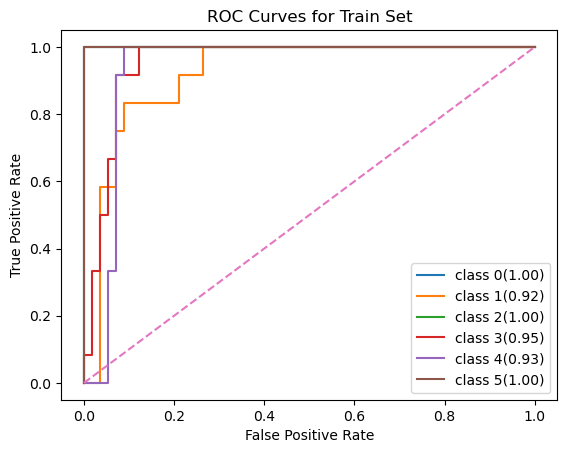

In [25]:
# train set
y_scores = result.decision_function(trainX)

fpr = {}
tpr = {}
roc_auc = {}

for i in range(6):
    fpr[i], tpr[i],_ = roc_curve(trainY, y_scores[:, i],pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(6):
    plt.plot(fpr[i],tpr[i], label=f'class {i}(%0.2f)'%roc_auc[i])

    
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC Curves for Train Set')
plt.show()

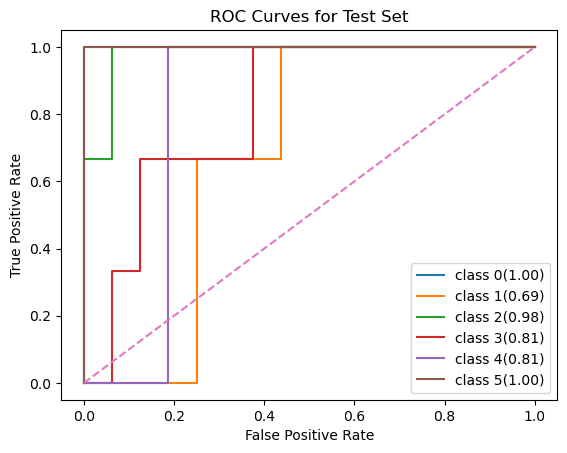

In [26]:
# test set
# draw ROC
y_scores = result.decision_function(testX)

fpr = {}
tpr = {}
roc_auc = {}

for i in range(6):
    fpr[i], tpr[i],_ = roc_curve(testY, y_scores[:, i],pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(6):
    plt.plot(fpr[i],tpr[i], label=f'class {i}(%0.2f)'%roc_auc[i])

    
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC Curves for Test Set')
plt.show()



#### ii. Naive Bayes

In [27]:
# https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html

In [28]:
best_test_error = 0
best_l = 0
for l in range(1,21):
    newTrainSet = breakTimeSeries(trainingSet, l)
    trainX, trainY = labelalldatasets(newTrainSet, 'train')
    trainX = TimeDomainFeatures(trainX)
    #print(trainX, trainY)
     
    newTestSet = breakTimeSeries(testingSet, l)
    testX, testY = labelalldatasets(newTestSet, 'test')
    testX = TimeDomainFeatures(testX)
    #print(testX, testY)
    
    '''
    xTrainNormalization = preprocessing.scale(trainX)
    xTestNormalization = preprocessing.scale(testX)
    '''   
    model = GaussianNB()
    result = model.fit(trainX, trainY)
    
    train_score = result.score(trainX, trainY)
    test_score = result.score(testX, testY)
    if 1-test_score > best_test_error:
        best_test_error = 1-test_score
        best_l = l
    print('L:', l, '\tAccuracy:', test_score, '\ttest error:', 1- test_score)
print('best test error is:', best_test_error, 'at', best_l )  

L: 1 	Accuracy: 0.8947368421052632 	test error: 0.10526315789473684
L: 2 	Accuracy: 0.8421052631578947 	test error: 0.1578947368421053
L: 3 	Accuracy: 0.8947368421052632 	test error: 0.10526315789473684
L: 4 	Accuracy: 0.8947368421052632 	test error: 0.10526315789473684
L: 5 	Accuracy: 0.8947368421052632 	test error: 0.10526315789473684
L: 6 	Accuracy: 0.8947368421052632 	test error: 0.10526315789473684
L: 7 	Accuracy: 0.8421052631578947 	test error: 0.1578947368421053
L: 8 	Accuracy: 0.8421052631578947 	test error: 0.1578947368421053
L: 9 	Accuracy: 0.8947368421052632 	test error: 0.10526315789473684
L: 10 	Accuracy: 0.8421052631578947 	test error: 0.1578947368421053
L: 11 	Accuracy: 0.8421052631578947 	test error: 0.1578947368421053
L: 12 	Accuracy: 0.8421052631578947 	test error: 0.1578947368421053
L: 13 	Accuracy: 0.8421052631578947 	test error: 0.1578947368421053
L: 14 	Accuracy: 0.8947368421052632 	test error: 0.10526315789473684
L: 15 	Accuracy: 0.8421052631578947 	test error: 0

confusion matrix on test set
 [[4 0 0 0 0 0]
 [0 3 0 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 2 1 0]
 [0 0 0 2 1 0]
 [0 0 0 0 0 3]]


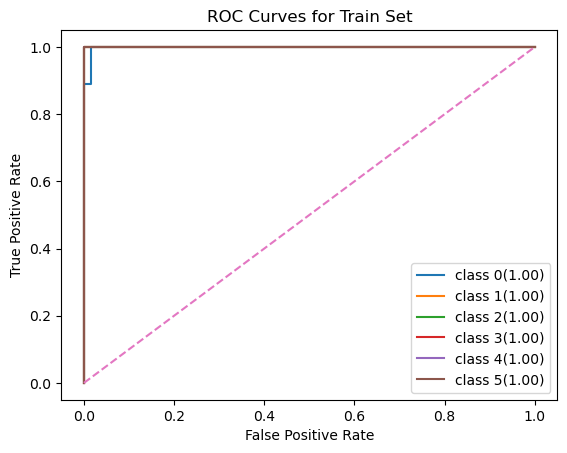

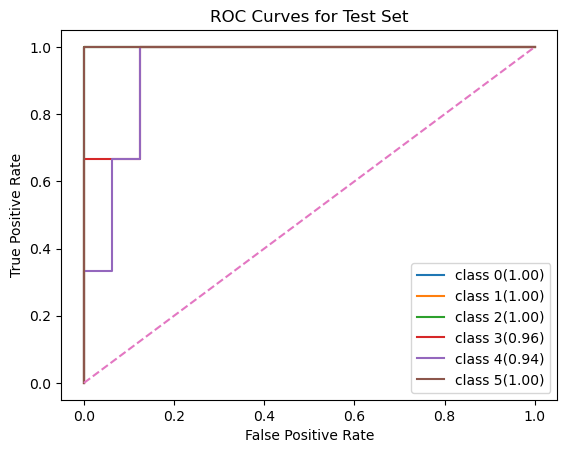

In [29]:
# select L = 2 to draw ROC
newTrainSet = breakTimeSeries(trainingSet, 2)
trainX, trainY = labelalldatasets(newTrainSet, 'train')
trainX = TimeDomainFeatures(trainX)
# print(trainX, trainY)

newTestX = breakTimeSeries(testingSet, 2)
testX, testY = labelalldatasets(newTestX, 'test')
testX = TimeDomainFeatures(testX)
model = GaussianNB()
result = model.fit(trainX, trainY)

yTestPredict = result.predict(testX)

cnf_Matrix = confusion_matrix(testY, yTestPredict, labels=[0,1,2,3,4,5])
print('confusion matrix on test set\n', cnf_Matrix )

# train set
y_scores = result.predict_proba(trainX)

fpr = {}
tpr = {}
roc_auc = {}

for i in range(6):
    fpr[i], tpr[i],_ = roc_curve(trainY, y_scores[:, i],pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(6):
    plt.plot(fpr[i],tpr[i], label=f'class {i}(%0.2f)'%roc_auc[i])

    
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC Curves for Train Set')
plt.show()

# test set
# draw ROC
y_scores = result.predict_proba(testX)

fpr = {}
tpr = {}
roc_auc = {}

for i in range(6):
    fpr[i], tpr[i],_ = roc_curve(testY, y_scores[:, i],pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(6):
    plt.plot(fpr[i],tpr[i], label=f'class {i}(%0.2f)'%roc_auc[i])

    
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC Curves for Test Set')
plt.show()

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

In [30]:
best_test_error = 0
best_l = 0
for l in range(1,21):
    newTrainSet = breakTimeSeries(trainingSet, l)
    trainX, trainY = labelalldatasets(newTrainSet, 'train')
    trainX = TimeDomainFeatures(trainX)
    #print(trainX, trainY)
     
    newTestSet = breakTimeSeries(testingSet, l)
    testX, testY = labelalldatasets(newTestSet, 'test')
    testX = TimeDomainFeatures(testX)
    #print(testX, testY)
 
    model = MultinomialNB()
    result = model.fit(trainX, trainY)
    
    train_score = result.score(trainX, trainY)
    test_score = result.score(testX, testY)
    if 1-test_score > best_test_error:
        best_test_error = 1-test_score
        best_l = l
    print('L:', l, '\tAccuracy:', test_score, '\ttest error:', 1- test_score)
print('best test error is:', best_test_error, 'at', best_l )  

L: 1 	Accuracy: 0.8947368421052632 	test error: 0.10526315789473684
L: 2 	Accuracy: 0.8947368421052632 	test error: 0.10526315789473684
L: 3 	Accuracy: 0.9473684210526315 	test error: 0.052631578947368474
L: 4 	Accuracy: 0.8947368421052632 	test error: 0.10526315789473684
L: 5 	Accuracy: 0.8947368421052632 	test error: 0.10526315789473684
L: 6 	Accuracy: 0.8947368421052632 	test error: 0.10526315789473684
L: 7 	Accuracy: 0.8947368421052632 	test error: 0.10526315789473684
L: 8 	Accuracy: 0.9473684210526315 	test error: 0.052631578947368474
L: 9 	Accuracy: 0.8947368421052632 	test error: 0.10526315789473684
L: 10 	Accuracy: 0.9473684210526315 	test error: 0.052631578947368474
L: 11 	Accuracy: 0.9473684210526315 	test error: 0.052631578947368474
L: 12 	Accuracy: 0.9473684210526315 	test error: 0.052631578947368474
L: 13 	Accuracy: 0.9473684210526315 	test error: 0.052631578947368474
L: 14 	Accuracy: 0.9473684210526315 	test error: 0.052631578947368474
L: 15 	Accuracy: 0.9473684210526315 

confusion matrix on test set
 [[4 0 0 0 0 0]
 [0 3 0 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 2 1 0]
 [0 0 1 0 2 0]
 [0 0 0 0 0 3]]


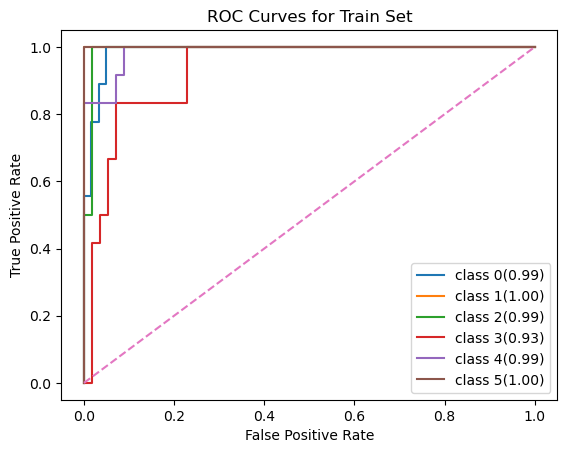

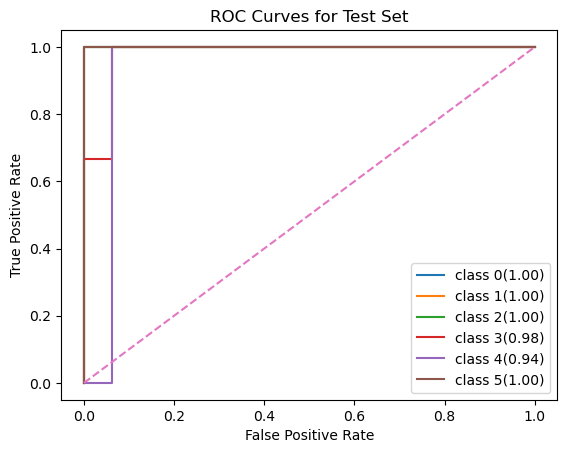

In [31]:
# select L = 1 to draw ROC
newTrainSet = breakTimeSeries(trainingSet, 1)
trainX, trainY = labelalldatasets(newTrainSet, 'train')
trainX = TimeDomainFeatures(trainX)
# print(trainX, trainY)

newTestX = breakTimeSeries(testingSet, 1)
testX, testY = labelalldatasets(newTestX, 'test')
testX = TimeDomainFeatures(testX)
model = MultinomialNB()
result = model.fit(trainX, trainY)

yTestPredict = result.predict(testX)

cnf_Matrix = confusion_matrix(testY, yTestPredict, labels=[0,1,2,3,4,5])
print('confusion matrix on test set\n', cnf_Matrix )

# train set
y_scores = result.predict_proba(trainX)

fpr = {}
tpr = {}
roc_auc = {}

for i in range(6):
    fpr[i], tpr[i],_ = roc_curve(trainY, y_scores[:, i],pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(6):
    plt.plot(fpr[i],tpr[i], label=f'class {i}(%0.2f)'%roc_auc[i])

    
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC Curves for Train Set')
plt.show()

# test set
# draw ROC
y_scores = result.predict_proba(testX)

fpr = {}
tpr = {}
roc_auc = {}

for i in range(6):
    fpr[i], tpr[i],_ = roc_curve(testY, y_scores[:, i],pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(6):
    plt.plot(fpr[i],tpr[i], label=f'class {i}(%0.2f)'%roc_auc[i])

    
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC Curves for Test Set')
plt.show()

#### ii. Comparison

#### In this problem, GaussianNB is better for multi-class classification.
#### From the results and figures above, it seems that GaussianNB produce larger AUC for all classes in the test set. 

## 3. ISLR 4.8.3

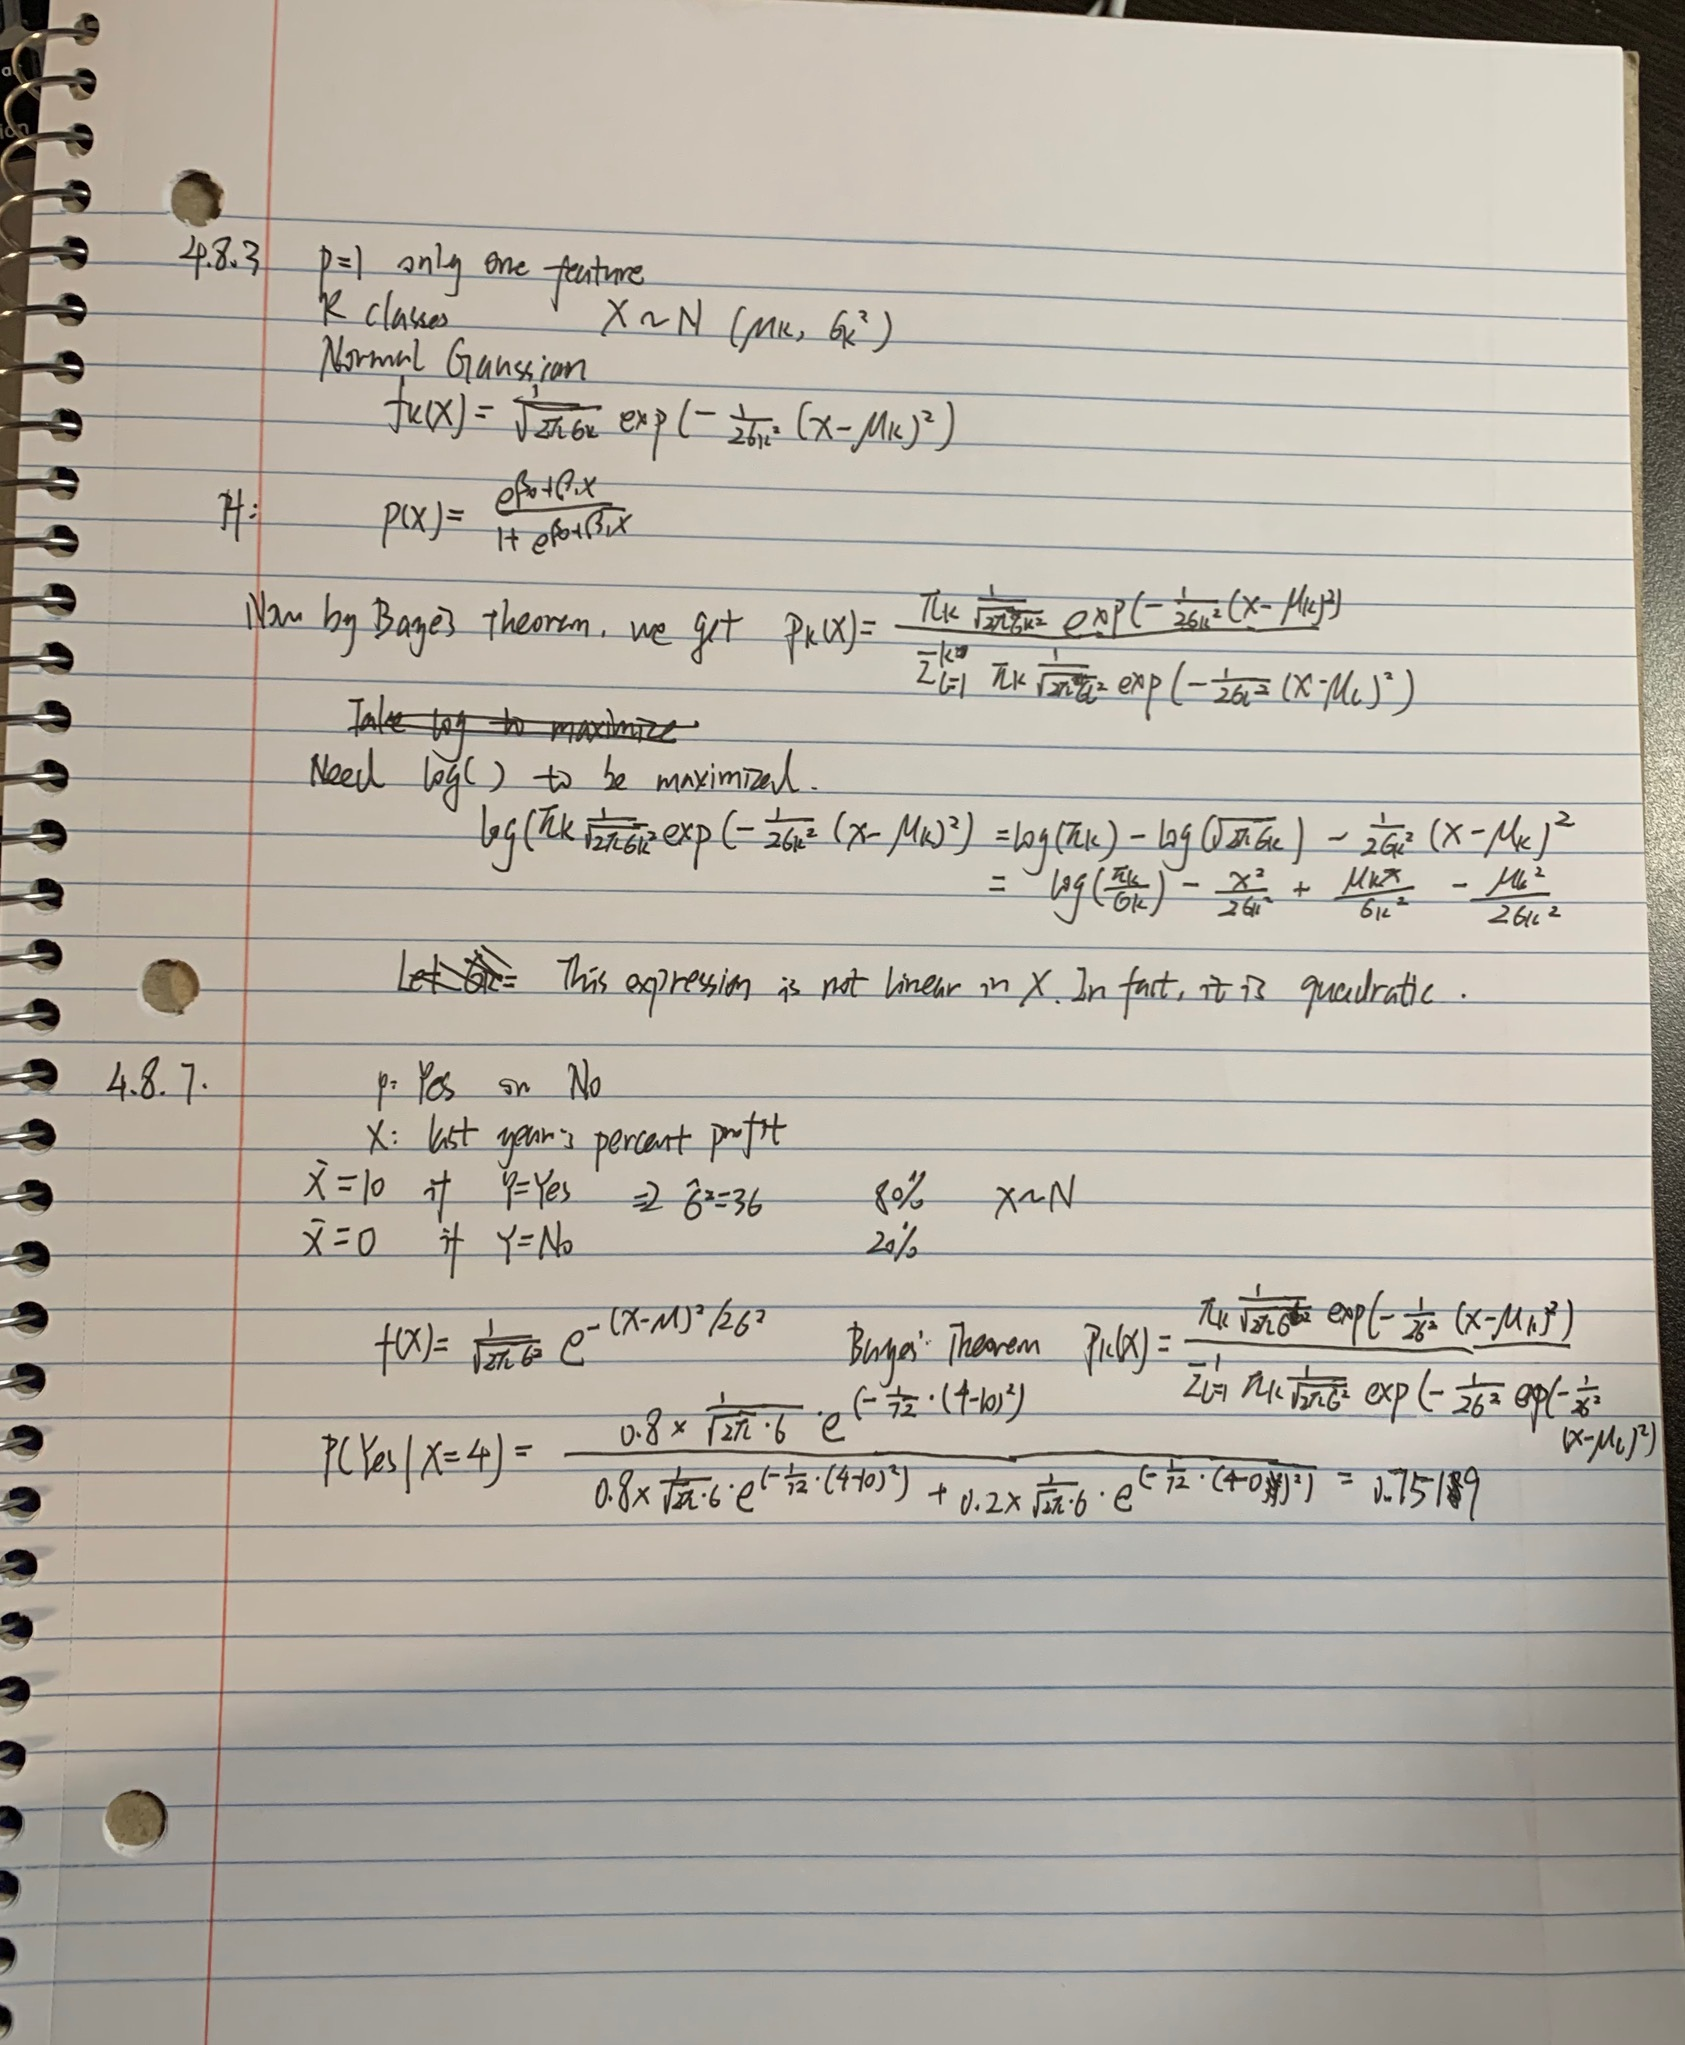

## 4. ISLR 4.8.7

#### see picture above

## 5.1. Extra Practice ISLR 4.8.4

## 5.2. Extra Practice ISLR 4.8.9

## Reference


https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html<br>
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html<br>
https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-definitions<br>
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html<br> https://github.com/SuprajaKrovvidi/DSCI-552-Machine-Learning-for-Data-Science/blob/master/Homework3/notebook/DSCI552_HW3_Ruihao_Wang_9867439484.ipynb <br>
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html<br>
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html<br>
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html<br>
https://www.statology.org/statsmodels-logistic-regression/<br>
https://data.library.virginia.edu/logistic-regression-four-ways-with-python/<br>
https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/<br>
https://imbalanced-learn.org/stable/over_sampling.html<br>
https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc<br>
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html<br>
https://stackoverflow.com/questions/14463277/how-to-disable-python-warnings<br>
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html<br>
https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html<br>
https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html<br>